In [11]:
#import
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt

# Let the passengers board into the airplane

In [12]:
# Define simulation function
def simulate_boarding():

    #Initialize
    #Define number of rows and columns
    n_rows = 33
    n_cols = 6

    #Calculate number of passengers
    n_pass = n_rows * n_cols

    #Create seat matrix, using -1 to represent unoccupied seats
    seats = np.zeros((n_rows, n_cols))
    seats[:, :] = -1

    #Create aisle array
    aisle_q = np.zeros(n_rows)
    aisle_q[:] = -1

    #Create initial passenger number queue
    pass_q = [int(i) for i in range(n_pass)]
    pass_q = np.array(pass_q)
    
    
    
    #Account for passenger ages and physical passenger disabilities
    #Define the parameters for the age distribution
    mean_age = 40
    stddev_age = 15

    # Generate passenger ages based on the custom distribution
    passenger_ages = np.random.normal(mean_age, stddev_age, n_pass)
    # Ensure the ages are non-negative
    passenger_ages = np.maximum(passenger_ages, 0)
    # Round the ages to whole numbers
    passenger_ages = np.round(passenger_ages)
    
    passenger_disabilities = np.random.choice([0, 1], n_pass, p=[0.95, 0.05])  # 10% chance of having a disability
    
    # Create an array of walking speeds based on age and disability
    walk_speeds = [get_walk_speed(age, disability) for age, disability in zip(passenger_ages, passenger_disabilities)]
    

    # Modify the assign_type to be "Grouped" based on the group_sizes provided
    if group_sizes is not None:
        rq, cq = AssignSeats(row_q_init, col_q_init, "Grouped", group_sizes)
    else:
        # Use the "BTF" method as the default
        rq, cq = AssignSeats(row_q_init, col_q_init, "BTF")

    
    #Create array for seat nos
    row_q_init = np.zeros(n_pass)
    col_q_init = np.zeros(n_pass)

    #Let's create moveto arrays
    moveto_loc = np.zeros(n_pass)
    moveto_time = np.zeros(n_pass)

    moveto_loc_dict = {i: j for i in pass_q for j in moveto_loc}
    moveto_time_dict = {i: j for i in pass_q for j in moveto_time}

    #Create function to assign seat number to each passenger
    def AssignSeats(rq, cq, assign_type, n_pass=n_pass, n_rows=n_rows):
        if assign_type == "SINP":
            #Initialize initial and final positions
            i = 0
            f = n_rows

            #Define column seating positions 
            c = [0, 5, 1, 4, 2, 3]

            #Define iteration counter
            count = 0

            #Assign queue
            while f <= n_pass:
                rq[i:f] = list(reversed(range(0, n_rows)))
                cq[i:f] = [c[count]] * n_rows
                i += n_rows
                f += n_rows
                count += 1
                

        if assign_type == "Random":
            #Initialize possible row positions, 0 to 32
            av_rows = np.arange(0, n_rows, 1)
            #Make as many copies of these positions as the number of columns
            av_rows = np.tile(av_rows, (n_cols, 1))
            av_rows = av_rows.T.flatten()

            #Initialize possible column positions
            av_cols = np.arange(0, n_cols, 1)
            #Make as many copies of these positions as the number of rows
            av_cols = np.tile(av_cols, (n_rows, 1)).flatten()

            #Create list of all possible seat positions
            av_seats = np.zeros((n_pass, 2))
            for i in range(n_pass):
                av_seats[i] = [av_rows[i], av_cols[i]]

            #Randomize seat positions
            np.random.shuffle(av_seats)
            
            rq = av_seats[:, 0]
            cq = av_seats[:, 1]
            

        if assign_type == "BTF":
            av_rows = np.arange(0, n_rows, 1)
            av_rows = np.tile(av_rows, (n_cols, 1))
            av_rows = av_rows.T.flatten()
            av_cols = np.arange(0, n_cols, 1)
            av_cols = np.tile(av_cols, (n_rows, 1)).flatten()
            av_seats = np.zeros((n_pass, 2))
            for i in range(n_pass):
                av_seats[i] = [av_rows[i], av_cols[i]]

            #Same as randomize except randomization is limited to specific groups
            group1 = av_seats[:48]
            np.random.shuffle(group1)
            group2 = av_seats[48:96]
            np.random.shuffle(group2)
            group3 = av_seats[96:]
            np.random.shuffle(group3)
            av_seats_final = np.concatenate((group3, group2, group1))
            rq = av_seats_final[:, 0]
            cq = av_seats_final[:, 1]

        if assign_type == "FTB":
            av_rows = np.arange(0, n_rows, 1)
            av_rows = np.tile(av_rows, (n_cols, 1))
            av_rows = av_rows.T.flatten()
            av_cols = np.arange(0, n_cols, 1)
            av_cols = np.tile(av_cols, (n_rows, 1)).flatten()
            av_seats = np.zeros((n_pass, 2))
            for i in range(n_pass):
                av_seats[i] = [av_rows[i], av_cols[i]]
            group1 = av_seats[:48]
            np.random.shuffle(group1)
            group2 = av_seats[48:96]
            np.random.shuffle(group2)
            group3 = av_seats[96:]
            np.random.shuffle(group3)

            #Same as BTF except order of groups is swapped
            av_seats_final = np.concatenate((group1, group2, group3))
            rq = av_seats_final[:, 0]
            cq = av_seats_final[:, 1]

        if assign_type == "WMA":
            window_1 = np.array([0] * n_rows)
            rows_1 = np.arange(0, n_rows, 1)
            window_2 = np.array([5] * n_rows)
            rows_2 = np.arange(0, n_rows, 1)
            window = np.concatenate((window_1, window_2))
            rows = np.concatenate((rows_1, rows_2))
            av_seats_w = np.column_stack((rows, window))
            np.random.shuffle(av_seats_w)

            middle_1 = np.array([1] * n_rows)
            middle_2 = np.array([4] * n_rows)
            middle = np.concatenate((middle_1, middle_2))
            av_seats_m = np.column_stack((rows, middle))
            np.random.shuffle(av_seats_m)

            aisle_1 = np.array([2] * n_rows)
            aisle_2 = np.array([3] * n_rows)
            aisle = np.concatenate((aisle_1, aisle_2))
            av_seats_a = np.column_stack((rows, aisle))
            np.random.shuffle(av_seats_a)

            av_seats = np.concatenate((av_seats_w, av_seats_m, av_seats_a))
            rq = av_seats[:, 0]
            cq = av_seats[:, 1]

        if assign_type == "Southwest":
            #Make an array [0,5,0,5,...]
            window = np.array([0, 5] * n_rows)

            #Make an array [0,0,1,1,2,2,...]
            rows_1 = np.arange(0, n_rows, 1)
            rows_2 = np.arange(0, n_rows, 1)
            rows = np.ravel(np.column_stack((rows_1, rows_2)))

            w_seats = np.column_stack((rows, window))
            w_group1 = w_seats[:32, :]
            w_group2 = w_seats[32:, :]

            aisle = np.array([2, 3] * n_rows)
            a_seats = np.column_stack((rows, aisle))
            a_group1 = a_seats[:32, :]
            a_group2 = a_seats[32:, :]

            mega_group1 = np.concatenate((w_group1, a_group1))
            np.random.shuffle(mega_group1)
            mega_group2 = np.concatenate((w_group2, a_group2))
            np.random.shuffle(mega_group2)

            w_and_a = np.concatenate((mega_group1, mega_group2))

            middle = np.array([1, 4] * n_rows)
            m_seats = np.column_stack((rows, middle))
            m_group1 = m_seats[:32, :]
            np.random.shuffle(m_group1)
            m_group2 = m_seats[32:, :]
            np.random.shuffle(m_group2)

            av_seats = np.concatenate((w_and_a, m_group1, m_group2))
            rq = av_seats[:, 0]
            cq = av_seats[:, 1]

        return rq, cq


    ####################################################

    #Create function to move passengers into the aircraft
    def MoveToAisle(t, aisle_q, pass_q, sum_time):
        if t > sum_time[0]:
            if aisle_q[0] == -1:
                aisle_q[0] = pass_q[0].copy()
                pass_q = np.delete(pass_q, 0)
                sum_time = np.delete(sum_time, 0)
        return aisle_q, pass_q, sum_time


    ###################################################
    
    def get_walk_speed(age, disability):
        if age > 70 or age < 8:
            if disability == 1:
                mean_time = 1.2  # 20% increase for age > 70 or < 8 and disability
            else:
                mean_time = 1.2  # 20% increase for age > 70 or < 8 and no disability
        elif disability == 1:
            mean_time = 1.5  # 50% increase for passengers with disabilities
        else:
            mean_time = 1.0  # Default mean_time for other passengers

        stddev_time = 0.2
        walk_speed = np.random.normal(loc=mean_time, scale=stddev_time)
        return walk_speed
    
    


    ##################################################

    # Assign seating order
    row_q, col_q = AssignSeats(row_q_init, col_q_init, "BTF")

    # Create array for times
    mean_time = 1.
    stddev_time = 0.2
    # Random numbers from a normal distribution with mean = mean_time and standard deviation stddev_time
    time_q = walk_speeds

    # Define multipliers (+2 for stowing luggage)
    # Empty row
    empty_mult = 1 + 2
    # Aisle occupied
    aisle_mult = 4 + 2
    # Middle occupied
    middle_mult = 5 + 2
    # Aisle and middle occupied
    aisle_middle_mult = 7 + 2

    # Create seat and speed dictionary
    pass_dict = {}
    time_dict = {}

    seat_nos = np.column_stack((row_q, col_q))
    for i in range(n_pass):
        pass_dict[i] = seat_nos[i]

    for i in range(n_pass):
        time_dict[i] = time_q[i]

    # Create sum time array
    sum_time = np.zeros(n_pass)
    for i in range(n_pass):
        sum_time[i] = sum(time_q[:i+1])

    # Define initial conditions
    time = 0
    time_step = 0.1
    exit_sum = np.sum(pass_q)
    pass_sum = np.sum(seats)

    while pass_sum != exit_sum:
        # Try to move passenger inside the plane if passengers are left
        if pass_q.size != 0:
            aisle_q, pass_q, sum_time = MoveToAisle(time, aisle_q, pass_q, sum_time)

        # Scan the aisle first for non-negative units (passengers)
        for passg in aisle_q:
            if passg != -1:
                # Store the row of the passenger in the aisle
                row = int(np.where(aisle_q == passg)[0][0])
                # See if move has been assigned to the passenger in the aisle
                if moveto_time_dict[passg] != 0:
                    # If move has been assigned, check if it is time to move
                    if time > moveto_time_dict[passg]:
                        # If it is time to move, follow the procedure below
                        # Check if move is forward in the aisle or to the seat
                        if moveto_loc_dict[passg] == "a":
                            # If move is in the aisle, check if the position ahead is empty
                            if aisle_q[row + 1] == -1:
                                # If the position is empty, move the passenger ahead and free the position behind
                                aisle_q[row + 1] = passg
                                aisle_q[row] = -1
                                # Set moves to 0 again
                                moveto_loc_dict[passg] = 0
                                moveto_time_dict[passg] = 0
                        elif moveto_loc_dict[passg] == "s":
                            # If the move is to the seat,
                            # Find the seat row and column of the passenger
                            passg_row = int(pass_dict[passg][0])
                            passg_col = int(pass_dict[passg][1])
                            # Set the seat matrix position to the passenger number
                            seats[passg_row, passg_col] = passg
                            # Free the aisle
                            aisle_q[row] = -1
                elif moveto_time_dict[passg] == 0:
                    # If the move hasn't been assigned to the passenger
                    # Check the passenger's seat location
                    passg_row = int(pass_dict[passg][0])
                    passg_col = int(pass_dict[passg][1])
                    if passg_row == row:
                        # If the passenger is at the row where his/her seat is
                        # Designate the move type as seat
                        moveto_loc_dict[passg] = "s"
                        # Check what type of seat: aisle, middle, or window
                        # Depending upon the seat type, designate when it is time to move
                        if passg_col == 0:
                            if seats[passg_row, 1] != -1 and seats[passg_row, 2] != -1:
                                moveto_time_dict[passg] = time + aisle_middle_mult * time_dict[passg]
                            elif seats[passg_row, 1] != -1:
                                moveto_time_dict[passg] = time + middle_mult * time_dict[passg]
                            elif seats[passg_row, 2] != -1:
                                moveto_time_dict[passg] = time + aisle_mult * time_dict[passg]
                            else:
                                moveto_time_dict[passg] = time + empty_mult * time_dict[passg]
                        elif passg_col == 5:
                            if seats[passg_row, 4] != -1 and seats[passg_row, 3] != -1:
                                moveto_time_dict[passg] = time + aisle_middle_mult * time_dict[passg]
                            elif seats[passg_row, 4] != -1:
                                moveto_time_dict[passg] = time + middle_mult * time_dict[passg]
                            elif seats[passg_row, 3] != -1:
                                moveto_time_dict[passg] = time + aisle_mult * time_dict[passg]
                            else:
                                moveto_time_dict[passg] = time + empty_mult * time_dict[passg]
                        elif passg_col == 1:
                            if seats[passg_row, 2] != -1:
                                moveto_time_dict[passg] = time + aisle_mult * time_dict[passg]
                            else:
                                moveto_time_dict[passg] = time + empty_mult * time_dict[passg]
                        elif passg_col == 4:
                            if seats[passg_row, 3] != -1:
                                moveto_time_dict[passg] = time + aisle_mult * time_dict[passg]
                            else:
                                moveto_time_dict[passg] = time + empty_mult * time_dict[passg]
                        elif passg_col == 2 or passg_col == 3:
                            moveto_time_dict[passg] = time + empty_mult * time_dict[passg]
                    elif passg_row != row:
                        # If the passenger is not at the row where his/her seat is
                        # Designate the movement type as aisle
                        moveto_loc_dict[passg] = "a"
                        # Designate the time to move
                        moveto_time_dict[passg] = time + time_dict[passg]

        # Iteration timekeeping
        time += time_step
        pass_sum = np.sum(seats)

        """
        print("Current state:")
        print("Time:", time)
        print("Passenger queue:", pass_q)
        print("Aisle queue:", aisle_q)
        """

    return time


Average boarding time for 100 simulations: 522.55
5th percentile boarding time: 489.96
95th percentile boarding time: 557.48


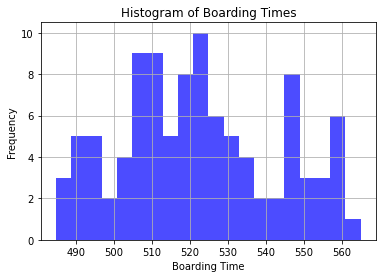

In [13]:
# Number of simulations
num_simulations = 100

boarding_times = []

for _ in range(num_simulations):
    result = simulate_boarding()
    if result > 0:
        boarding_times.append(result)
    else:
        print("negative number!")

# Calculate the average time
average_time = sum(boarding_times) / len(boarding_times)

# Calculate percentiles
percentile_5 = np.percentile(boarding_times, 5)
percentile_95 = np.percentile(boarding_times, 95)

print("Average boarding time for {} simulations: {:.2f}".format(len(boarding_times), average_time))
print("5th percentile boarding time: {:.2f}".format(percentile_5))
print("95th percentile boarding time: {:.2f}".format(percentile_95))

# Create a histogram of boarding times
plt.hist(boarding_times, bins=20, color='blue', alpha=0.7)
plt.xlabel("Boarding Time")
plt.ylabel("Frequency")
plt.title("Histogram of Boarding Times")
plt.grid(True)
plt.show()

In [14]:

# Number of simulations
num_simulations = 100  # You can adjust this number

# Define the percentage of passengers not following the prescribed boarding method
percent_passengers_not_following = [0.0, 0.1, 0.2, 0.3, 0.4]  # You can adjust these values

for percent_not_following in percent_passengers_not_following:
    boarding_times = []

    for _ in range(num_simulations):
        result = simulate_boarding(percent_not_following=percent_not_following)
        if result > 0:
            boarding_times.append(result)

    # Calculate and print the average boarding time
    average_time = sum(boarding_times) / len(boarding_times)
    print(f"Average boarding time for {num_simulations} simulations with {percent_not_following * 100}% not following: {average_time:.2f} minutes")

# Now, let's perform the sensitivity analysis based on the average number of carry-on bags per flight

# Define the average number of carry-on bags per flight
avg_carryon_bags = [0.5, 1.0, 1.5, 2.0, 2.5]  # You can adjust these values

for avg_bags in avg_carryon_bags:
    boarding_times = []

    for _ in range(num_simulations):
        result = simulate_boarding(avg_carryon_bags=avg_bags)
        if result > 0:
            boarding_times.append(result)

    # Calculate and print the average boarding time
    average_time = sum(boarding_times) / len(boarding_times)
    print(f"Average boarding time for {num_simulations} simulations with {avg_bags} average carry-on bags: {average_time:.2f} minutes")


TypeError: simulate_boarding() got an unexpected keyword argument 'percent_not_following'

# Trash Code

In [46]:
#Initialize possible row positions, 0 to 32
av_rows = np.arange(0, 33, 1)
#Make as many copies of these positions as the number of columns
av_rows = np.tile(av_rows, (6, 1))
av_rows = av_rows.T.flatten()


#Initialize possible column positions
av_cols = np.arange(0, 6, 1)
#Make as many copies of these positions as the number of rows
av_cols = np.tile(av_cols, (33, 1)).flatten()

#Create list of all possible seat positions
av_seats = np.zeros((198, 2))
for i in range(198):
    av_seats[i] = [av_rows[i], av_cols[i]]

#Randomize seat positions
np.random.shuffle(av_seats)
    
rq = av_seats[:, 0]
cq = av_seats[:, 1]
    
print('this is rq', rq)
print ('this is cq', cq)
  


this is rq [27. 24.  5. 27.  6. 23. 26.  0.  7. 22.  0. 15. 17.  8. 14.  9.  9.  5.
  4. 16.  7. 20. 25.  7. 25. 30. 32.  5. 10. 25. 30. 31. 23. 10. 21. 18.
 29. 24.  9. 27.  5. 22.  7. 15. 10.  6. 14.  6.  0.  1.  8.  9. 21. 20.
 15. 20. 14. 32. 20. 26.  0.  3.  2. 21. 31. 16. 11. 11. 13. 23.  2. 15.
 28.  9. 14.  9. 31. 30. 21. 11. 16. 19. 30.  2.  8. 22. 29. 18. 15.  6.
 28. 25. 27.  1. 20. 30. 32. 32.  7.  6. 28.  3.  6. 23. 13. 16. 13.  1.
 12. 11.  8. 17. 27. 21.  0. 25. 17. 26. 13. 24. 31. 19. 31.  3. 12.  4.
 18.  2. 25.  3. 16. 24. 28. 13. 23. 10. 20. 32. 21. 17. 10. 10. 17.  3.
 26. 24.  5. 13.  4. 11. 27.  5.  1. 29. 18.  0. 12. 16.  8. 12. 29.  4.
 31. 17. 19.  7.  8. 29. 23. 19. 30.  3. 29. 19. 12. 14. 22. 22.  1. 32.
 24.  2. 19. 15.  4.  4. 22. 28. 26. 28. 14. 18.  2. 26. 18. 12.  1. 11.]
this is cq [3. 0. 3. 1. 3. 1. 1. 0. 4. 5. 4. 2. 3. 1. 1. 1. 0. 0. 2. 3. 0. 2. 2. 5.
 5. 2. 4. 1. 4. 0. 0. 1. 3. 1. 5. 0. 5. 4. 2. 2. 4. 1. 1. 0. 0. 0. 4. 1.
 2. 5. 4. 4. 2. 5. 5. 4. 0. 